# **Assignment 01:  Traffic Sign Classification**

 Importing the Required Librarires


In [65]:
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
import csv
import os
import pandas as pd
from numpy import genfromtxt
from google.colab.patches import cv2_imshow
from scipy import stats
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq
from sklearn.svm import LinearSVC
from scipy.cluster.vq import vq
from texttable import Texttable
from sklearn.tree import DecisionTreeClassifier
import argparse
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import sklearn
from sklearn.ensemble import AdaBoostClassifier

from sklearn.cluster import KMeans

Extracting data from DataSet "CS67_Fall2022_ A1_Dataset.zip"

In [ ]:
!unzip /content/'CS67_Fall2022_ A1_Dataset.zip' -d /content/New_data

Archive:  /content/CS67_Fall2022_ A1_Dataset.zip
replace /content/New_data/00001/00025_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/New_data/00001/00025_00000.ppm  
  inflating: /content/New_data/00001/00025_00001.ppm  
  inflating: /content/New_data/00001/00025_00002.ppm  
  inflating: /content/New_data/00001/00029_00000.ppm  
  inflating: /content/New_data/00001/00029_00001.ppm  
  inflating: /content/New_data/00001/00029_00002.ppm  
  inflating: /content/New_data/00001/00079_00000.ppm  
  inflating: /content/New_data/00001/00079_00001.ppm  
  inflating: /content/New_data/00001/00079_00002.ppm  
  inflating: /content/New_data/00001/00136_00000.ppm  
  inflating: /content/New_data/00001/00136_00001.ppm  
  inflating: /content/New_data/00001/00136_00002.ppm  
  inflating: /content/New_data/00001/00143_00000.ppm  
  inflating: /content/New_data/00001/00143_00001.ppm  
  inflating: /content/New_data/00001/00143_00002.ppm  
  inflating: /content/New_data/00001/

Creating training and test data csv files

In [89]:
label=0
for dir in os.listdir('/content/New_data'):
    label=int(dir)
    #opening the train text file from each folder
    f = open('/content/New_data/'+str(dir)+'/train.txt', "r")
    line=f.readlines()
    #For every folder, read the train.txt file and store the path of the images into train_data.csv file
    with open('train_data.csv', 'a', newline='') as file:
       writer = csv.writer(file)
       for i in range(0,len(line)):
         writer.writerow(['/content/New_data/'+str(dir)+'/'+str(line[i][:-1]), label])
    f.close()
    

In [90]:
#Repeating the above steps for the test data
for dir in os.listdir('/content/New_data'): 
    # Labels are assigned according to the folder names
     label=int(dir)
     # opening the test text file from each folder
     f = open('/content/New_data/'+str(dir)+'/test.txt', "r")  
     line2=f.readlines()     
     #For every folder, read the test.txt file and store the path of the images into test_data.csv file
     with open('test_data.csv', 'a', newline='') as file:
      writer = csv.writer(file)
      for i in range(0,len(line2)):
         writer.writerow(['/content/New_data/'+str(dir)+'/'+str(line2[i][:-1]), label])
     f.close()


 Reading train and test images and their respective labels

In [91]:
train_im=[]
train_labels=[]
test_im=[]
test_labels=[]
#Read the train and test data csv files
train_read=pd.read_csv('train_data.csv', sep=',',header=None)
test_read=pd.read_csv('test_data.csv', sep=',',header=None)
for i in range(0,len(train_read)):
  #reading train images 
  img=cv2.imread(train_read[0][i])
  #grayscale
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #resize
  img=cv2.resize(img,(90,90))
  #histogram equivalization
  img = cv2.equalizeHist(img)
  # Append the images to train_im
  train_im.append(img)
  # append the labels to the train_labels
  train_labels.append(train_read[1][i])
print(len(train_labels))
print(len(train_im))

800
800


In [92]:
#Repeating the above steps for the test data
for i in range(0,len(test_read)):
  #reading test images 
  img=cv2.imread(test_read[0][i])
  #grayscale
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  #resize
  img=cv2.resize(img,(90,90))
  #histogram equivalization
  img = cv2.equalizeHist(img)
  #Append the images to test_im
  test_im.append(img)
  #append the labels to the test_set_labels
  test_labels.append(test_read[1][i])

print(len(test_im))

200


# **Using Fast and ORB for Feature Extraction and SVM for Classification**
# ** The Chosen Method for the Implementation of the Task **

## **Feature Extraction using Fast and Orb**

In [93]:
descriptors=[]
keypoints=[]
y_train=[]
fast = cv2.FastFeatureDetector_create()
fast.setNonmaxSuppression(False)
#creating ORB object
orb=cv2.ORB_create(nfeatures=100)
for i in range(0,len(train_im)):
    #Using Fast to extract key points
    kp=fast.detect(train_im[i],None)
    #Using ORB  to find descriptors
    kp,descriptor= orb.compute(train_im[i], kp)
    
    if(len(kp)!=0):
      #append the descriptors to the descriptors list
      descriptors.append(descriptor)
      #append the keypoints to the keypoint list
      keypoints.append(kp)
      y_train.append(train_read[1][i])

print(len(y_train))

800


In [94]:
#descriptor stacking
ds=descriptors[0]
for descriptor in descriptors[1:]:
    ds=np.vstack((ds,descriptor))
print(len(y_train))

800


Clustering on descriptors

In [95]:
descriptors_float=ds.astype(float)
#setting number of clusters=160
k=160 
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(descriptors),k),"float32")
for i in range(len(descriptors)):
    words,distance=vq(descriptors[i],voc)
    for w in words:
        im_features[i][w]+=1

# **Training**

Fitting SVM 

In [96]:
clf=LinearSVC(max_iter=90000)
clf.fit(im_features,np.array(y_train))

LinearSVC(max_iter=90000)

## **Testing**


The pipeline for training is now repeated for the test data



In [97]:
des_test=[]
test_set_labels=[]
for i in range(0,len(test_im)):
    kp=fast.detect(test_im[i],None)
    kp, descriptor_test = orb.compute(test_im[i],  kp)
    if(len(kp)!=0):
      des_test.append(descriptor_test)
      test_set_labels.append(test_labels[i])

print(len(test_set_labels))
print(len(test_im))

200
200


In [98]:
test_ds=des_test[0]
#stacking all the descriptors for test data
for descriptor in des_test[1:]:
    test_ds=np.vstack((test_ds,descriptor))

In [99]:
#calculating features for test data
test_features=np.zeros((len(test_set_labels),k),"float32")
for i in range(len(test_set_labels)):
    words,distance=vq(des_test[i],voc)
    for w in words:
        test_features[i][w]+=1

# **Prediction**

In [100]:
test_predict_classes=[]
#running model on test features for predictions
for i in clf.predict(test_features):
        test_predict_classes.append(i)

# **Quatitative and Qualitative Results**

In [101]:
TP=0
test_images_misclassified=[]
test_labels_misclassified=[]
actual_labels=[]
correct_class_im=[]
correct_class_labels=[]
for i in range(0,len(test_predict_classes)):
  
  if(test_set_labels[i]==test_predict_classes[i]):
    TP+=1
    correct_class_im.append(test_im[i])
    correct_class_labels.append(test_predict_classes[i])
  else:
    test_images_misclassified.append(test_im[i])
    test_labels_misclassified.append(test_predict_classes[i])
    actual_labels.append(test_set_labels[i])


Quantitative Scores


In [102]:

f1 =f1_score(test_set_labels, test_predict_classes,average='macro')
#print(f1)
precision = precision_score(test_set_labels, test_predict_classes,average='macro')
#print(precision)
recall = recall_score(test_set_labels, test_predict_classes,average='macro')
print("Accuracy: ",TP/len(test_predict_classes)*100)
print("F1 Score: ",f1)
print("Precision Score:",precision)
print("Recall Score:",recall)
print("True Positive: ", TP)



Accuracy:  90.0
F1 Score:  0.9010100062539086
Precision Score: 0.9064642857142857
Recall Score: 0.9
True Positive:  180


Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


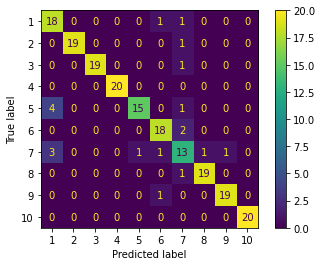

In [103]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
plot_confusion_matrix(clf, test_features, test_set_labels) 

## Qualitative Results

Correctly Classified Images
Test Image: 


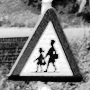

Test Label:  4
---------------------
Test Image: 


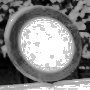

Test Label:  7
---------------------
Test Image: 


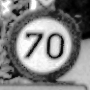

Test Label:  2
---------------------
Test Image: 


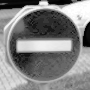

Test Label:  5
---------------------
Test Image: 


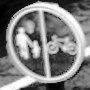

Test Label:  9
---------------------
Incorrectly Classified Image
Test Image: 


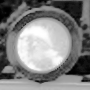

Predicted Label:  1
True Label:  7
---------------------
Test Image: 


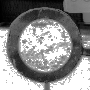

Predicted Label:  6
True Label:  7
---------------------
Test Image: 


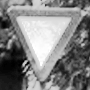

Predicted Label:  7
True Label:  6
---------------------
Test Image: 


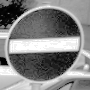

Predicted Label:  1
True Label:  5
---------------------
Test Image: 


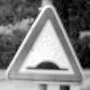

Predicted Label:  7
True Label:  1
---------------------


In [105]:
print("Correctly Classified Images")
for i in range(0,len(correct_class_im),40):
  print("Test Image: ")
  cv2_imshow(correct_class_im[i])
  print("Test Label: ",correct_class_labels[i])
  print("---------------------")

print("Incorrectly Classified Image")
for i in range(0,len(test_images_misclassified),4):
  print("Test Image: ")
  cv2_imshow(test_images_misclassified[i])
  print("Predicted Label: ",test_labels_misclassified[i])
  print("True Label: ",actual_labels[i])
  print("---------------------")



# **Classification By Decision Trees Classifier with Fast and ORB for Feature Detection**

In [106]:
#Training the data on Decision Tree Classifier
clf1 = DecisionTreeClassifier()
clf1.fit(im_features,np.array(y_train))

DecisionTreeClassifier()

In [107]:
#Prediction by decision tree classifier
test_predict_classes_dt=[]
#running model on test features for predictions
for i in clf1.predict(test_features):
        test_predict_classes_dt.append(i)

In [108]:
#Evaluation Metrics for Decision Tree Classifier
TP_dt=0
test_images_misclassified_dt=[]
test_labels_misclassified_dt=[]
actual_labels_dt=[]
correct_class_im_dt=[]
correct_class_labels_dt=[]

for i in range(0,len(test_predict_classes_dt)):
  
  if(test_set_labels[i]==test_predict_classes_dt[i]):
    TP_dt+=1
    correct_class_im_dt.append(test_im[i])
    correct_class_labels_dt.append(test_predict_classes_dt[i])
  else:
    test_images_misclassified_dt.append(test_im[i])
    test_labels_misclassified_dt.append(test_predict_classes_dt[i])
    actual_labels_dt.append(test_set_labels[i])



In [109]:
f1_dt =f1_score(test_set_labels, test_predict_classes_dt,average='macro')
#print(f1)
precision_dt = precision_score(test_set_labels, test_predict_classes_dt,average='macro')
#print(precision)
recall_dt = recall_score(test_set_labels, test_predict_classes_dt,average='macro')
print("Accuracy: ",TP_dt/len(test_predict_classes_dt)*100)
print("F1 Score: ",f1_dt)
print("Precision Score:",precision_dt)
print("Recall Score:",recall_dt)
print("True Positive: ", TP_dt)



Accuracy:  86.5
F1 Score:  0.8673126571201026
Precision Score: 0.8784632034632034
Recall Score: 0.8649999999999999
True Positive:  173


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


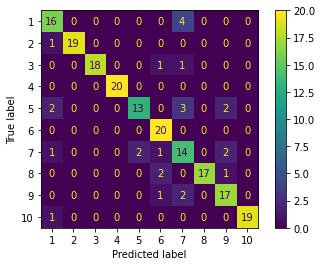

In [110]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
plot_confusion_matrix(clf1, test_features, test_set_labels) 

# **Classification By AdaBoost with Fast and ORB for Feature Detection**

In [111]:
#Training the dataset on AdaBoost Classifier
clf2=AdaBoostClassifier()
clf2.fit(im_features,np.array(y_train))

AdaBoostClassifier()

In [112]:
#Prediction by AdaBoost Classifier
test_predict_classes_ada=[]
#running model on test features for predictions
for i in clf2.predict(test_features):
        test_predict_classes_ada.append(i)

In [113]:
#Evaluation Metrics for AdaBoost Classifier
TP_ada=0
test_images_misclassified_ada=[]
test_labels_misclassified_ada=[]
actual_labels_ada=[]
correct_class_im_ada=[]
correct_class_labels_ada=[]

for i in range(0,len(test_predict_classes_ada)):
  
  if(test_set_labels[i]==test_predict_classes_ada[i]):
    TP_ada+=1
    correct_class_im_ada.append(test_im[i])
    correct_class_labels_ada.append(test_predict_classes_ada[i])
  else:
    test_images_misclassified_ada.append(test_im[i])
    test_labels_misclassified_ada.append(test_predict_classes_ada[i])
    actual_labels_ada.append(test_set_labels[i])



In [114]:
f1_ada =f1_score(test_set_labels, test_predict_classes_ada,average='macro')
#print(f1)
precision_ada = precision_score(test_set_labels, test_predict_classes_ada,average='macro')
#print(precision)
recall_ada = recall_score(test_set_labels, test_predict_classes_ada,average='macro')
print("Accuracy: ",TP_ada/len(test_predict_classes_ada)*100)
print("F1 Score: ",f1_ada)
print("Precision Score:",precision_ada)
print("Recall Score:",recall_ada)
print("True Positive ", TP_ada)



Accuracy:  38.5
F1 Score:  0.3121524128045867
Precision Score: 0.30392123926838377
Recall Score: 0.38499999999999995
True Positive  77


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


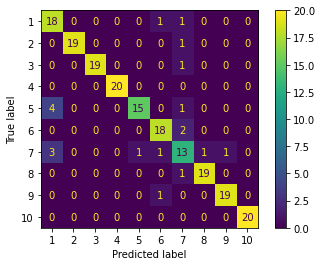

In [115]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
plot_confusion_matrix(clf, test_features, test_set_labels) 

**Feature Extraction using FAST+ORB and classification by SVM is our chosen model as it gives the highest quantitative scores**

# **Using SIFT for Feature Detection and SVM for Classification**

# **Training**
SIFT for Feature Extraction

In [128]:
#by using sift
descriptors=[]
keypoints=[]
y_train=[]
sift = cv2.xfeatures2d.SIFT_create()


for i in range(0,len(train_im)):
    #Using SIFT to extract key points
    img=cv2.imread(train_read[0][i])
    kp, des = sift.detectAndCompute(img, None)    
    if(len(kp)!=0):
      #append the descriptors to the descriptors list
      descriptors.append(des)
      #append the keypoints to the keypoint list
      keypoints.append(kp)
      y_train.append(train_read[1][i])

print(len(y_train))

800


In [129]:
#descriptor stacking
ds=descriptors[0]
for descriptor in descriptors[1:]:
    ds=np.vstack((ds,descriptor))

print(len(y_train))

800


Clustering using K-Means

In [130]:
descriptors_float=ds.astype(float)
#setting number of clusters=160
k=160
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(descriptors),k),"float32")
for i in range(len(descriptors)):
    words,distance=vq(descriptors[i],voc)
    for w in words:
        im_features[i][w]+=1

In [131]:
#fitting SVM Model on training dataset
clf=LinearSVC(max_iter=90000)
clf.fit(im_features,np.array(y_train))

LinearSVC(max_iter=90000)

# **Testing**

Repeating the same pipeline for the test data

In [132]:
#by using sift
des_test=[]
keypoints_test=[]
test_set_labels=[]
sift = cv2.xfeatures2d.SIFT_create()


for i in range(0,len(test_labels)):
    #Using SIFT to extract key points
    img=cv2.imread(test_read[0][i])
    kp, des = sift.detectAndCompute(img, None)    
    if(len(kp)!=0):
      #append the descriptors to the descriptors list
      des_test.append(des)
      #append the keypoints to the keypoint list
      keypoints_test.append(kp)
      test_set_labels.append(test_labels[i])

print(len(test_set_labels))

200


In [133]:
test_ds=des_test[0]
for descriptor in des_test[1:]:
    test_ds=np.vstack((test_ds,descriptor))

In [134]:
testset_features=np.zeros((len(test_set_labels),k),"float32")
for i in range(len(test_set_labels)):
    words,distance=vq(des_test[i],voc)
    for w in words:
        testset_features[i][w]+=1

In [135]:
test_classes_predict=[]
#Using the SVM model for prediction
for i in clf.predict(testset_features):
        test_classes_predict.append(i)
        #print(test_classes_predict)

# **Quantitative Results**

In [136]:
TP=0
incorrect_classified_images=[]
incorrect_classified_labels=[]
actual_labels=[]
correct_class_images=[]
correct_class_labels=[]



In [137]:
for i in range(0,len(test_classes_predict)):
  if(test_set_labels[i]==test_classes_predict[i]):
    TP+=1
    correct_class_images.append(test_im[i])
    correct_class_labels.append(test_classes_predict[i])
  else:
    incorrect_classified_images.append(test_classes_predict[i])
    incorrect_classified_labels.append(test_classes_predict[i])
    actual_labels.append(test_set_labels[i])


# **Quantitative Results**

In [138]:
f1 =f1_score(test_set_labels, test_classes_predict,average='macro')
#print(f1)
precision = precision_score(test_set_labels, test_classes_predict,average='macro')
#print(precision)
recall = recall_score(test_set_labels, test_classes_predict,average='macro')
print("Accuracy: ",TP/len(test_classes_predict)*100)
print("F1 Score: ",f1)
print("Precision Score:",precision)
print("Recall Score:",recall)
print("True Positive ", TP)




Accuracy:  75.0
F1 Score:  0.7527839139817034
Precision Score: 0.7625133981198055
Recall Score: 0.75
True Positive  150


Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


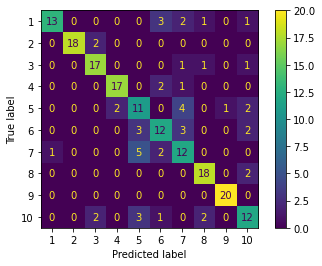

In [139]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
plot_confusion_matrix(clf, testset_features, test_set_labels) 